# Analyzing the benchmark with 2 covariates

In [1]:
# Setup
import pandas as pd
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

plot_path = "./plots/"

Functions for getting classification metrics for every result based on ground truth

In [4]:
def get_scores(df, add=""):
    """
    Calculates extended binary classification summary statistics, such as TPR, TNR, youden index, f1-score, MCC

    Parameters
    ----------
    df: DataFrame
        Must contain columns tp, tn, fp, fn

    Returns
    -------
    df: DataFrame
        Same df with added columns tpr, tnr, precision, accuracy, youden, f1_score, mcc
    """
    tp = df[f"tp{add}"].astype("float64")
    tn = df[f"tn{add}"].astype("float64")
    fp = df[f"fp{add}"].astype("float64")
    fn = df[f"fn{add}"].astype("float64")

    tpr = (tp / (tp + fn)).fillna(0)
    df[f"tpr{add}"] = tpr
    tnr = (tn / (tn + fp)).fillna(0)
    df[f"tnr{add}"] = tnr
    precision = (tp / (tp + fp)).fillna(0)
    df[f"precision{add}"] = precision
    fdr = (fp / (tp + fp)).fillna(0)
    df[f"fdr{add}"] = fdr
    acc = ((tp + tn) / (tp + tn + fp + fn)).fillna(0)
    df[f"accuracy{add}"] = acc

    df[f"youden{add}"] = tpr + tnr - 1
    df[f"f1_score{add}"] = 2 * (tpr * precision / (tpr + precision)).fillna(0)

    df[f"mcc{add}"] = (((tp * tn) - (fp * fn)) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))).fillna(0)

    return df


def classify(row):
    p = row["num_otus"]

    gt = np.zeros(p)

    if type(row["effect_otus"]) == str:
        eff = eval(row["effect_otus"].replace("[ ", "[").replace("  ", " ").replace(" ", ", "))
    else:
        eff = row["effect_otus"]
    gt[eff] = 1

    pred = np.zeros(p)
    res = [int(x) for x in eval(row["result_otus"])]
    pred[[x for x in res if x < p]] = 1

    tn, fp, fn, tp = confusion_matrix(gt, pred).ravel()

    return tp, tn, fp, fn

Read benchmark data and add ground truth nodes and features. Then calculate classification metrics

In [5]:
# Read data
tree_agg_path = "../../../tascCODA_data/benchmarks/2_covariates/results/"

tree_agg_res = []

for f in os.listdir(tree_agg_path):
    if f.startswith("result_df"):
        tree_agg_res.append(pd.read_csv(tree_agg_path + f, index_col=0))

tree_agg_df = pd.concat(tree_agg_res)
tree_agg_df

,model,reg_method,lambda,phi,result_nodes,result_otus,mean_log_prob,acc_rate,num_samples,effect_size,num_otus,dataset_id
0,tree_agg,x_1_mult,NaN,0.0,['39'],"[43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]",-1530.117979,0.86335,10,0.5,30,10
1,tree_agg,x_1_mult,NaN,0.0,"['33', '39']","[13, 14, 15, 16, 43, 44, 45, 46, 47, 48, 49, 5...",-1521.796781,0.85635,10,0.5,30,11
2,tree_agg,x_1_mult,NaN,0.0,"['33', '39']","[13, 14, 15, 16, 43, 44, 45, 46, 47, 48, 49, 5...",-1532.198723,0.83650,10,0.5,30,12
3,tree_agg,x_1_mult,NaN,0.0,['39'],"[43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]",-1528.992981,0.85235,10,0.5,30,13
4,tree_agg,x_1_mult,NaN,0.0,"['33', '39']","[13, 14, 15, 16, 43, 44, 45, 46, 47, 48, 49, 5...",-1634.155036,0.85245,10,0.5,30,14
...,...,...,...,...,...,...,...,...,...,...,...,...
5,tree_agg,new_3,NaN,-5.0,[],[],-1391.552435,0.91045,10,0.5,30,15
6,tree_agg,new_3,NaN,-5.0,[],[],-1135.301315,0.86235,10,0.5,30,16
7,tree_agg,new_3,NaN,-5.0,['33'],"[13, 14, 15, 16]",-1366.250397,0.83165,10,0.5,30,17
8,tree_agg,new_3,NaN,-5.0,"['33', '39']","[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]",-1371.497092,0.83360,10,0.5,30,18


In [6]:
# add ground truth
ground_truth = {
    10: ([0, 4, 12], [0, 4, 7, 8]),
    30: ([33, 7, 0], [0, 7, 13, 14, 15, 16]),
    50: ([61, 40, 5], [5, 40, 44, 45, 46, 47]),
    100: ([113, 72, 28], [72, 55, 56, 57, 58, 28])
}

tree_agg_df["effect_nodes"] = [ground_truth[x][0] for x in tree_agg_df["num_otus"]]
tree_agg_df["effect_otus"] = [ground_truth[x][1] for x in tree_agg_df["num_otus"]]
tree_agg_df

,model,reg_method,lambda,phi,result_nodes,result_otus,mean_log_prob,acc_rate,num_samples,effect_size,num_otus,dataset_id,effect_nodes,effect_otus
0,tree_agg,x_1_mult,NaN,0.0,['39'],"[43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]",-1530.117979,0.86335,10,0.5,30,10,"[33, 7, 0]","[0, 7, 13, 14, 15, 16]"
1,tree_agg,x_1_mult,NaN,0.0,"['33', '39']","[13, 14, 15, 16, 43, 44, 45, 46, 47, 48, 49, 5...",-1521.796781,0.85635,10,0.5,30,11,"[33, 7, 0]","[0, 7, 13, 14, 15, 16]"
2,tree_agg,x_1_mult,NaN,0.0,"['33', '39']","[13, 14, 15, 16, 43, 44, 45, 46, 47, 48, 49, 5...",-1532.198723,0.83650,10,0.5,30,12,"[33, 7, 0]","[0, 7, 13, 14, 15, 16]"
3,tree_agg,x_1_mult,NaN,0.0,['39'],"[43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]",-1528.992981,0.85235,10,0.5,30,13,"[33, 7, 0]","[0, 7, 13, 14, 15, 16]"
4,tree_agg,x_1_mult,NaN,0.0,"['33', '39']","[13, 14, 15, 16, 43, 44, 45, 46, 47, 48, 49, 5...",-1634.155036,0.85245,10,0.5,30,14,"[33, 7, 0]","[0, 7, 13, 14, 15, 16]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,tree_agg,new_3,NaN,-5.0,[],[],-1391.552435,0.91045,10,0.5,30,15,"[33, 7, 0]","[0, 7, 13, 14, 15, 16]"
6,tree_agg,new_3,NaN,-5.0,[],[],-1135.301315,0.86235,10,0.5,30,16,"[33, 7, 0]","[0, 7, 13, 14, 15, 16]"
7,tree_agg,new_3,NaN,-5.0,['33'],"[13, 14, 15, 16]",-1366.250397,0.83165,10,0.5,30,17,"[33, 7, 0]","[0, 7, 13, 14, 15, 16]"
8,tree_agg,new_3,NaN,-5.0,"['33', '39']","[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]",-1371.497092,0.83360,10,0.5,30,18,"[33, 7, 0]","[0, 7, 13, 14, 15, 16]"


In [7]:
# classification
classes = tree_agg_df.apply(classify, axis=1)

tree_agg_df["tp"] = [x[0] for x in classes]
tree_agg_df["tn"] = [x[1] for x in classes]
tree_agg_df["fp"] = [x[2] for x in classes]
tree_agg_df["fn"] = [x[3] for x in classes]
tree_agg_df = get_scores(tree_agg_df)
tree_agg_df

,model,reg_method,lambda,phi,result_nodes,result_otus,mean_log_prob,acc_rate,num_samples,effect_size,...,fp,fn,tpr,tnr,precision,fdr,accuracy,youden,f1_score,mcc
0,tree_agg,x_1_mult,NaN,0.0,['39'],"[43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]",-1530.117979,0.86335,10,0.5,...,0,6,0.000000,1.000000,0.000000,0.000000,0.800000,0.000000,0.000000,0.000000
1,tree_agg,x_1_mult,NaN,0.0,"['33', '39']","[13, 14, 15, 16, 43, 44, 45, 46, 47, 48, 49, 5...",-1521.796781,0.85635,10,0.5,...,0,2,0.666667,1.000000,1.000000,0.000000,0.933333,0.666667,0.800000,0.784465
2,tree_agg,x_1_mult,NaN,0.0,"['33', '39']","[13, 14, 15, 16, 43, 44, 45, 46, 47, 48, 49, 5...",-1532.198723,0.83650,10,0.5,...,0,2,0.666667,1.000000,1.000000,0.000000,0.933333,0.666667,0.800000,0.784465
3,tree_agg,x_1_mult,NaN,0.0,['39'],"[43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]",-1528.992981,0.85235,10,0.5,...,0,6,0.000000,1.000000,0.000000,0.000000,0.800000,0.000000,0.000000,0.000000
4,tree_agg,x_1_mult,NaN,0.0,"['33', '39']","[13, 14, 15, 16, 43, 44, 45, 46, 47, 48, 49, 5...",-1634.155036,0.85245,10,0.5,...,0,2,0.666667,1.000000,1.000000,0.000000,0.933333,0.666667,0.800000,0.784465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,tree_agg,new_3,NaN,-5.0,[],[],-1391.552435,0.91045,10,0.5,...,0,6,0.000000,1.000000,0.000000,0.000000,0.800000,0.000000,0.000000,0.000000
6,tree_agg,new_3,NaN,-5.0,[],[],-1135.301315,0.86235,10,0.5,...,0,6,0.000000,1.000000,0.000000,0.000000,0.800000,0.000000,0.000000,0.000000
7,tree_agg,new_3,NaN,-5.0,['33'],"[13, 14, 15, 16]",-1366.250397,0.83165,10,0.5,...,0,2,0.666667,1.000000,1.000000,0.000000,0.933333,0.666667,0.800000,0.784465
8,tree_agg,new_3,NaN,-5.0,"['33', '39']","[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]",-1371.497092,0.83360,10,0.5,...,7,2,0.666667,0.708333,0.363636,0.636364,0.700000,0.375000,0.470588,0.311272


In [8]:
# add no. of effects and hamming distance
def get_num_eff(row):
    if row["model"] in ["tree_agg", "adaANCOM"]:
        return len([int(x) for x in eval(row["result_nodes"])])
    else:
        return len([int(x) for x in eval(row["result_otus"])])

num_eff =  classes = tree_agg_df.apply(get_num_eff, axis=1)
tree_agg_df["num_effects"] = num_eff + 0.001
tree_agg_df["hamming"] = tree_agg_df["fn"] + tree_agg_df["fp"]

Plots

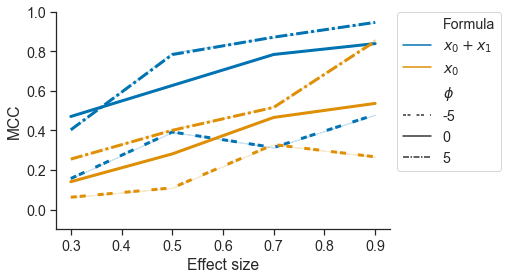

In [9]:
sns.set(style="ticks", font_scale=1.3)

g = sns.lineplot(data=tree_agg_df[tree_agg_df["reg_method"] != "x_1_mult"], x="effect_size", y="mcc",
                 hue="reg_method",
                 palette="colorblind",
                 style="phi",
                 legend=True,
                 ci=False,
                 dashes=[(2,1,2,4), "", (4,1,1,1)],
                 lw=3
            )
g.set(ylim=[-0.1,1])
sns.despine()
h,l = g.get_legend_handles_labels()
g.legend(handles=h, labels=["Formula", r"$x_0 + x_1$", r"$x_0$", r"$\phi$", "-5", "0", "5"], bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

plt.xlabel("Effect size")
plt.ylabel("MCC")
# plt.savefig(plot_path + "2_cov_mcc.svg", bbox_inches="tight", format="svg")
plt.show()


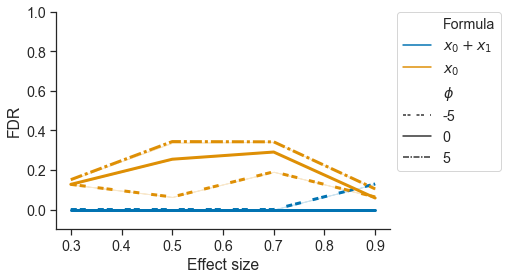

In [10]:
g = sns.lineplot(data=tree_agg_df[tree_agg_df["reg_method"] != "x_1_mult"], x="effect_size", y="fdr",
                 hue="reg_method",
                 palette="colorblind",
                 style="phi",
                 legend=True,
                 ci=False,
                 dashes=[(2,1,2,4), "", (4,1,1,1)],
                 lw=3
            )
g.set(ylim=[-0.1,1])
sns.despine()
h,l = g.get_legend_handles_labels()
g.legend(handles=h, labels=["Formula", r"$x_0 + x_1$", r"$x_0$", r"$\phi$", "-5", "0", "5"], bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

plt.xlabel("Effect size")
plt.ylabel("FDR")
#plt.savefig(plot_path + "2_cov_fdr.svg", bbox_inches="tight", format="svg")
plt.show()

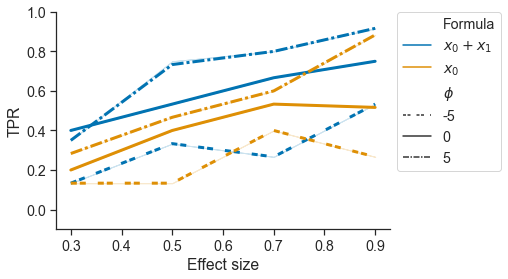

In [11]:
g = sns.lineplot(data=tree_agg_df[tree_agg_df["reg_method"] != "x_1_mult"], x="effect_size", y="tpr",
                 hue="reg_method",
                 palette="colorblind",
                 style="phi",
                 legend=True,
                 ci=False,
                 dashes=[(2,1,2,4), "", (4,1,1,1)],
                 lw=3
            )
g.set(ylim=[-0.1,1])
sns.despine()
h,l = g.get_legend_handles_labels()
g.legend(handles=h, labels=["Formula", r"$x_0 + x_1$", r"$x_0$", r"$\phi$", "-5", "0", "5"], bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

plt.xlabel("Effect size")
plt.ylabel("TPR")
#plt.savefig(plot_path + "2_cov_tpr.svg", bbox_inches="tight", format="svg")
plt.show()

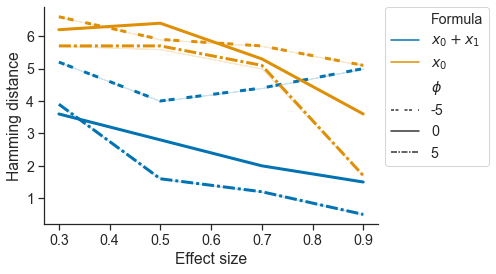

In [12]:
g = sns.lineplot(data=tree_agg_df[tree_agg_df["reg_method"] != "x_1_mult"], x="effect_size", y="hamming",
                 hue="reg_method",
                 palette="colorblind",
                 style="phi",
                 legend=True,
                 ci=False,
                 dashes=[(2,1,2,4), "", (4,1,1,1)],
                 lw=3
            )
# g.set(ylim=[-0.1,1])
sns.despine()
h,l = g.get_legend_handles_labels()
g.legend(handles=h, labels=["Formula", r"$x_0 + x_1$", r"$x_0$", r"$\phi$", "-5", "0", "5"], bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

plt.xlabel("Effect size")
plt.ylabel("Hamming distance")
#plt.savefig(plot_path + "2_cov_hamming.svg", bbox_inches="tight", format="svg")
plt.show()